In [1]:
import pandas as pd
from collections import Counter
import re
import neologdn
import emoji
import urllib
from janome.tokenizer import Tokenizer
from nltk import ngrams, FreqDist, ConditionalFreqDist, word_tokenize, pos_tag, download
import jieba
import jieba.posseg as pseg
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./lang.csv', header=None)
df.columns = ['word', 'lang']

In [3]:
lang_cnt = Counter(df['lang']).most_common()[:10]
lang_cnt = pd.DataFrame(lang_cnt)
lang_cnt.columns = ['Language', 'Counts']
lang_cnt = lang_cnt.set_index('Language')

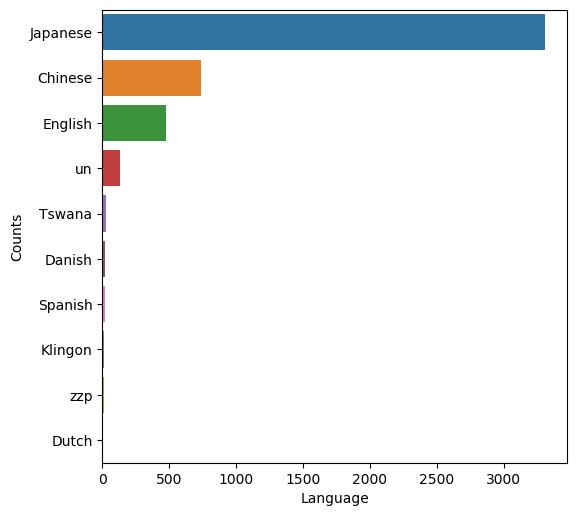

In [4]:
fig = plt.figure(figsize=(6, 6), dpi=100)
sns.barplot(lang_cnt['Counts'], lang_cnt.index)
plt.xlabel('Language')
plt.ylabel('Counts')
plt.show()
fig.savefig('./freq_lang.png')

In [5]:
# preprocessing
tmp = []
for line in df['word']:
    line = neologdn.normalize(line)
    line = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', line)
    line = re.sub(r'[!-/:-@[-`{-~]', r' ', line)
    line = re.sub(r'\d+', '0', line)
    line = ''.join(['' if c in emoji.UNICODE_EMOJI else c for c in line])
    tmp.append(line)

df['word'] = tmp
del tmp

In [6]:
jp = df[df['lang'] == 'Japanese']
en = df[df['lang'] == 'English']
ch = df[df['lang'] == 'Chinese']
#other = df[(df['lang'] != 'Japanese') & (df['lang'] != 'English') & (df['lang'] != 'Chinese')]

In [7]:
# JP
# stop word data
url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
urllib.request.urlretrieve(url, 'stop_word.txt')

with open('./stop_word.txt', 'r', encoding='utf_8') as f:
    stop_word = [i.rstrip('\n') for i in f]

# morphological analysis
t = Tokenizer(mmap=True)
re_hiragana = re.compile(r'^[あ-ん]+$')
name = []
tokens_jp = []

for line in jp['word']:
    tmp = []
    malist = t.tokenize(line)
    
    for word in malist:
        base, part = word.surface, word.part_of_speech
        
        # extract Meishi ^ not stop word
        if '名詞' in part and base not in stop_word:
            hiragana = re_hiragana.fullmatch(base) 
            
            # Hiragana (one character) or 'ー'
            if hiragana!=None and len(hiragana[0])==1 or base=='ー':
                continue
            
            tokens_jp.append(base)
del tmp

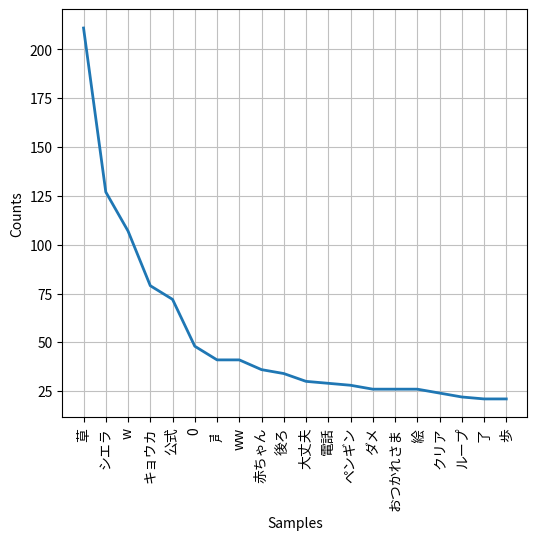

In [8]:
# plot word frequency
tokens_l = [word.lower() for word in tokens_jp]
fd = FreqDist(tokens_l)
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.gcf().subplots_adjust(bottom=0.2)
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
fd.plot(20)
plt.show()
fig.savefig('./freq_jp.png')

In [9]:
download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/yura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yura/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
# EN
tokens_en = []
re_eng = re.compile(r'^[a-z]+$')

for line in en['word']:
    malist = word_tokenize(line)
    malist = pos_tag(malist)
    
    for word in malist:
        if 'NN' in word:
            re_check = re_eng.fullmatch(word[0])
            
            if re_check!=None and len(re_check[0])==1:
                continue
            
            tokens_en.append(word[0])

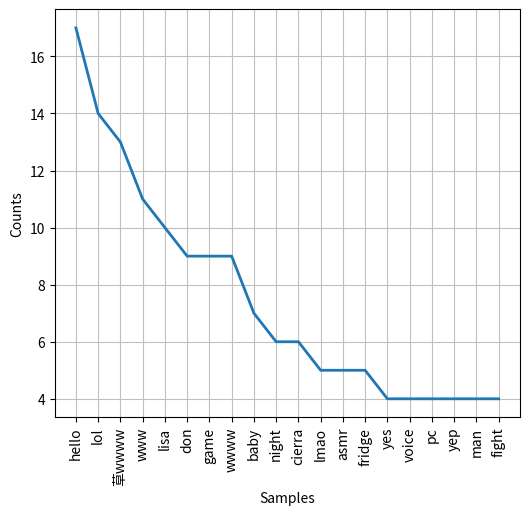

In [11]:
# plot word frequency
tokens_l = [word.lower() for word in tokens_en]
fd = FreqDist(tokens_l)
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.gcf().subplots_adjust(bottom=0.2)
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
fd.plot(20)
plt.show()
fig.savefig('./freq_en.png')

In [12]:
#CH
tokens_ch = []
jieba.load_userdict('./data/custom_dict_ch.txt')
#jieba.enable_paddle()

for line in ch['word']:
    malist = jieba.posseg.cut(line, use_paddle=False)
    
    for word, flag in malist:
        if flag == 'n':
            tokens_ch.append(word)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.684 seconds.
Prefix dict has been built successfully.


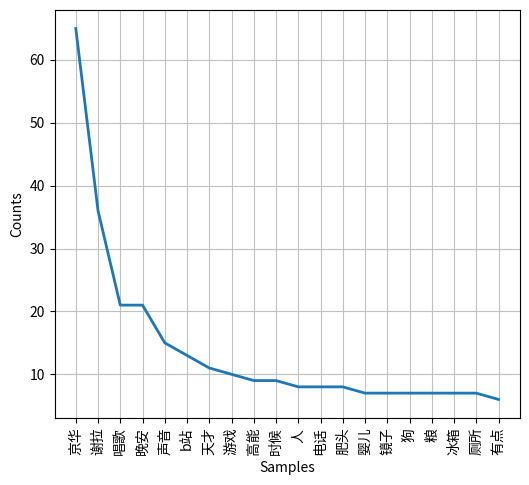

In [13]:
# plot word frequency
tokens_l = [word.lower() for word in tokens_ch]
fd = FreqDist(tokens_l)
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.gcf().subplots_adjust(bottom=0.2)
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
fd.plot(20)
plt.show()
fig.savefig('./freq_ch.png')